# Creating coordinates for S2S bias correction model

The file created by this notebook will be used as features during ML training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

In [2]:
def regrid_mask(ds, variable, reuse_weights=False):
    """
    Function to regrid onto coarser ERA5 grid (0.25-degree).

    Args:
        ds (xarray dataset): file.
        variable (str): variable.
        reuse_weights (boolean): Whether to use precomputed weights to speed up calculation.
                                 Defaults to ``False``.
    Returns:
        Regridded mask file for use with machine learning model.
    """
    ds_out = xe.util.grid_2d(lon0_b=0-0.5,   lon1_b=360-0.5, d_lon=1., 
                             lat0_b=-90-0.5, lat1_b=91,      d_lat=1.)

    regridder = xe.Regridder(ds, ds_out, method='nearest_s2d', reuse_weights=reuse_weights)

    return regridder(ds[variable])


def encode_cyclic(data, period):
    """
    Encode the given data as cyclic values.

    Parameters:
    - data: Array-like or scalar containing the values to be encoded.
    - period: The period or range of the cyclic values (e.g., 24 for hours of the day).

    Returns:
    - Encoded cyclic values between 0 and 2*pi.
    """
    radians = 2 * np.pi * data / period
    return np.sin(radians), np.cos(radians)


def encode_cycliclon(data, lon_name = 'lon'):
    """
    Encode the given data as cyclic values.

    Parameters:
    - data: Array of longitudes (0-360)
    
    Returns:
    - Data with cyclic values between -1 and 1 for longitudes
    """
    if np.max(data[lon_name].values) > 180:
        print('...Calculating cyclic longitudes...')
        new_lon = np.sin(np.deg2rad(data[lon_name])) #used sine so 0E is still 0
        data = data.assign_coords({lon_name: new_lon})
    else:
        print('ERROR: please provide longitudes in the format of 0-360E')
    
    return data


def normalize_lat(data, lat_name = 'lat'):
    """
    Normalize latitudes by 90

    Parameters:
    - data: Array of latitudes (-90-90)
    
    Returns:
    - data with normalized latitudes between -1 and 1 (latitudes/90)
    """

    new_lat = data[lat_name].values / 90.
    data = data.assign_coords({lat_name: new_lat})
    
    return data


def cartesian_conversion(lat, lon):
    """
    Input latitude and longitude as degrees.
    Longitude should be in 180 degrees (not 360).
    """
    x = np.cos(np.deg2rad(lat)) * np.cos(np.deg2rad(lon))
    y = np.cos(np.deg2rad(lat)) * np.sin(np.deg2rad(lon))
    z = np.sin(np.deg2rad(lat))
    return x, y, z

## First, land-sea handling
Here we use ERA5 land model data to create topo coordinate.

In [3]:
era5_lsm = xr.open_dataset(
    '/glade/scratch/molina/lsm_1279l4_0.1x0.1.grb_v4_unpack.nc') # land sea mask
new_era5_lsm = regrid_mask(
    era5_lsm.isel(time=0), 'lsm', reuse_weights=False) # regrid lsm

In [4]:
era5_land = xr.open_dataset(
    '/glade/scratch/molina/geo_1279l4_0.1x0.1.grib2_v4_unpack.nc') # land model geo file
era5_land = era5_land.isel(time=0) / 9.81 # geopotential altitude
new_era5_land = regrid_mask(
    era5_land, 'z', reuse_weights=False) # regrid geo

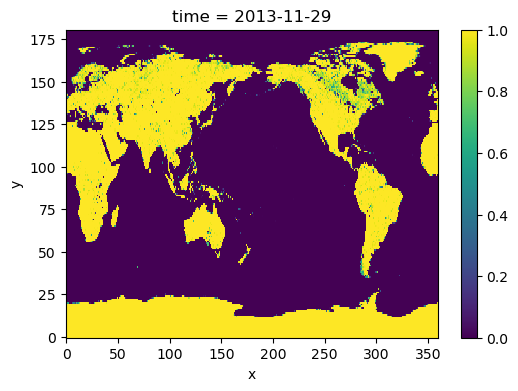

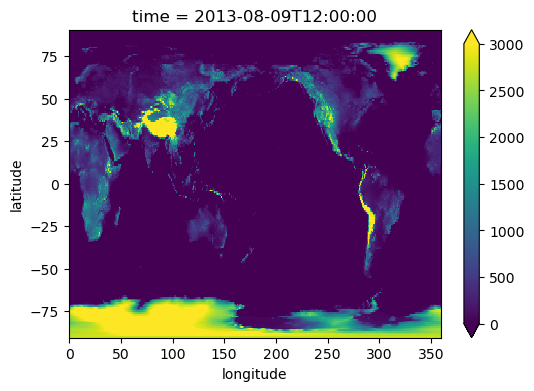

In [5]:
# converted to 1-degree global viz
new_era5_lsm.plot.pcolormesh('x','y',vmin=0,vmax=1,figsize=(6,4)); plt.show()
new_era5_land.plot.pcolormesh('lon','lat',vmin=0,vmax=3000,figsize=(6,4)); plt.show()

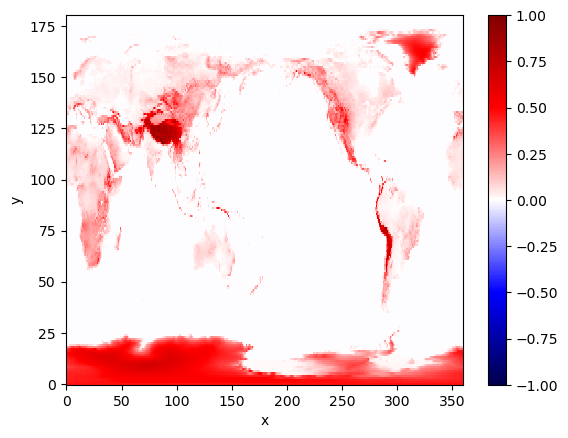

In [6]:
# lsm is zero where there is no land
# where lsm is zero or less, assign estimated surface geopotential altitude, else nan
# i.e., here we mask ocean
tmp_land = xr.where(new_era5_lsm > 0., new_era5_land, np.nan)
# where estimated surface height is less than zero, make zero, else keep land vals
# i.e., fix negative land
tmp_land = xr.where(tmp_land < 0., 0.0, tmp_land)
# where surface is not land, make -1 (we want ocean to be more different)
tmp_land = xr.where(tmp_land > 0., tmp_land, -1.)
# normalize by maximum values
tmp_land = tmp_land / tmp_land.max()
tmp_land.plot.pcolormesh(cmap='seismic'); plt.show()

In [7]:
tmp_land.to_netcdf('/glade/scratch/molina/s2s/CESM2_OBS/era5_lsm_topov2.nc') # save for future

# Second, lat/lon handling

Here we create lat/lon coordinates that are cyclical features for ML.

In [8]:
# tmp file for coords setting (dummy file)
ds0 = xr.open_dataset(
    '/glade/scratch/molina/s2s/CESM2/tas_2m_anom_cesm2cam6v2_11members_s2s_data.nc')

In [9]:
ds0

<xarray.Dataset>
Dimensions:     (lon: 360, lat: 181, lead: 46, time: 1195, date_range: 1195)
Coordinates:
  * date_range  (date_range) datetime64[ns] 1999-02-01 1999-02-08 ... 2021-12-27
  * lead        (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * time        (time) int64 1 2 3 4 5 6 7 ... 1190 1191 1192 1193 1194 1195
  * lat         (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon         (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    anom        (lon, lat, lead, time) float64 ...
    fcst        (time) |S10 ...
Attributes:
    File Author:  Maria J. Molina
    Ensembles:    ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'...

### Make longitude cyclic, normalize latitudes, and create ds_for_ml_coords

In [10]:
# setting values in place
ds0_cycliclon = encode_cycliclon(ds0, 'lon') # min = -1, max = 1
ds0_final = normalize_lat(ds0_cycliclon,'lat') # min = -1, max = 1

...Calculating cyclic longitudes...


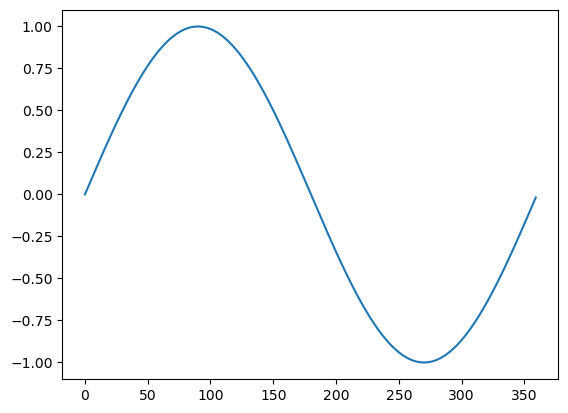

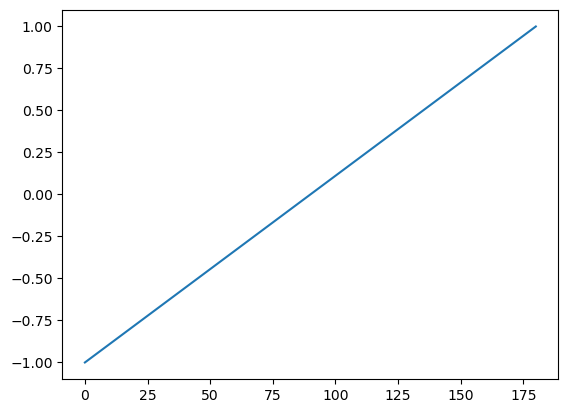

In [11]:
# check conversions worked
plt.plot(ds0_final.lon.values)
plt.show()
plt.plot(ds0_final.lat.values)
plt.show()

In [12]:
ds0_final

<xarray.Dataset>
Dimensions:     (lon: 360, lat: 181, lead: 46, time: 1195, date_range: 1195)
Coordinates:
  * date_range  (date_range) datetime64[ns] 1999-02-01 1999-02-08 ... 2021-12-27
  * lead        (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * time        (time) int64 1 2 3 4 5 6 7 ... 1190 1191 1192 1193 1194 1195
  * lat         (lat) float32 -1.0 -0.9889 -0.9778 -0.9667 ... 0.9778 0.9889 1.0
  * lon         (lon) float32 0.0 0.01745 0.0349 ... -0.05234 -0.0349 -0.01745
Data variables:
    anom        (lon, lat, lead, time) float64 ...
    fcst        (time) |S10 ...
Attributes:
    File Author:  Maria J. Molina
    Ensembles:    ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'...

### Reshape lat and lon to 2d arrays

In [13]:
# create 2d lat and lon arrays; shape (360, 181)
new_lats = np.repeat(np.expand_dims((ds0_final.lat.values), axis=0), 360, axis=0)
new_lons = np.repeat(np.expand_dims((ds0_final.lon.values), axis=1), 181, axis=1)

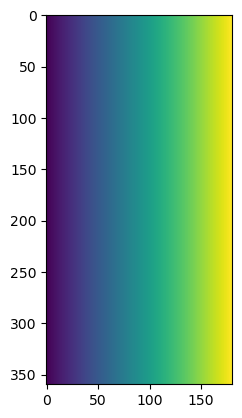

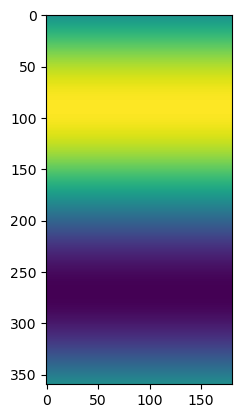

In [14]:
# quick viz
plt.imshow(new_lats); plt.show()
plt.imshow(new_lons); plt.show()

# Lastly, create data coordinate file.

This will be used for training ML.

In [15]:
# quick checks
print(tmp_land.min().values, tmp_land.max().values)
print(new_lats.min(), new_lats.max())
print(new_lons.min(), new_lons.max())

-0.00016702525067472442 1.0
-1.0 1.0
-1.0 1.0


In [16]:
# quick checks
print(tmp_land.transpose('x','y').shape)
print(new_lats.shape)
print(new_lons.shape)

(360, 181)
(360, 181)
(360, 181)


In [17]:
ds_for_ml_coords = xr.Dataset(
    data_vars=dict(
        top=(["x", "y"], tmp_land.transpose('x','y').values),
        lat=(["x", "y"], new_lats),
        lon=(["x", "y"], new_lons),
    ),
    coords=dict(
        x=(["x"], ds0.lon.values),
        y=(["y"], ds0.lat.values),
    ),
    attrs=dict(description="ML coords."),
)

In [18]:
ds_for_ml_coords

<xarray.Dataset>
Dimensions:  (x: 360, y: 181)
Coordinates:
  * x        (x) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * y        (y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    top      (x, y) float64 0.4617 0.4503 0.4387 ... -0.000167 -0.000167
    lat      (x, y) float32 -1.0 -0.9889 -0.9778 -0.9667 ... 0.9778 0.9889 1.0
    lon      (x, y) float32 0.0 0.0 0.0 0.0 ... -0.01745 -0.01745 -0.01745
Attributes:
    description:  ML coords.

In [19]:
ds_for_ml_coords.to_netcdf('/glade/scratch/molina/s2s/CESM2_OBS/ml_coordsv2.nc') # save